In [2]:
import os

import bk.load
import bk.compute
import bk.plot
import bk.signal

import numpy as np

import scipy as sp


import matplotlib.pyplot as plt
import matplotlib as mpl
import neuroseries as nts

import pycorrelate

import basefunction.pdc_tdf as pdc_tdf

In [4]:
%matplotlib widget

In [3]:
path = '/media/billel/GGLab-01-BK/DATA/Rat08-20130713/'
os.chdir(path)
bk.load.path = path
bk.load.rat = 8
bk.load.session = 'Rat08-20130713'
bk.load.day = 6

FileNotFoundError: [Errno 2] No such file or directory: '/media/billel/GGLab-01-BK/DATA/Rat08-20130713/'

In [5]:
states['sws'][0:1].as_units('s')

NameError: name 'states' is not defined

In [30]:
states = bk.load.states()
nrem_lfp = bk.load.lfp_in_intervals(166, 101, states['Rem'][0:1])

In [49]:
f, t, Sxx = sp.signal.spectrogram(nrem_lfp, 1250, nperseg=100, noverlap=75)

# plt.figure()
ax = plt.subplot(211)
plt.plot(nrem_lfp.as_units('s'))
plt.plot(bk.signal.passband(nrem_lfp, 40, 100).as_units('s'), 'r')
# bk.plot.intervals(states['sws'], 'grey')
plt.subplot(212, sharex=ax)
plt.pcolormesh(t+states['Rem'].as_units('s').iloc[0].start, f, Sxx)
plt.clim(0, 2000)
plt.ylim(0,100)

/home/billel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


(0.0, 100.0)

In [50]:
states['sws'].as_units('s')

,start,end
0,1448.0,1697.0
1,1777.0,1926.0
2,2104.0,2429.0
3,2826.0,3275.0
4,3383.0,3841.0
5,3888.0,3916.0
6,3970.0,3992.0
7,4024.0,4529.0
8,4568.0,4648.0
9,5044.0,5426.0


In [3]:
bk.load.current_session()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ Z:\Rat08\Rat08-20130713


True

In [4]:
neurons,metadata = bk.load.loadSpikeData(bk.load.path)

Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [23]:
%time t,psth = bk.compute.psth(neurons,neurons[0].as_units('s').index,0.001,[-0.5,.5])

15784it [00:51, 305.14it/s]


Wall time: 4min 46s


In [21]:
psth[:,:,t==0] = 0

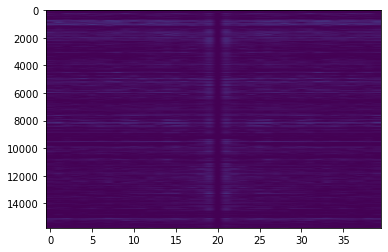

In [22]:
plt.imshow(psth[:,0,:],aspect='auto')

In [66]:
psth[t==0,0]=0

In [71]:
int(.5--.5/0.025)

20

In [73]:
np.arange(20)-int(20/2)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9])

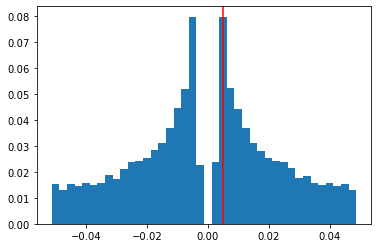

In [67]:
plt.bar(t,psth[:,0],t[1]-t[0])
plt.axvline(0.005,color = 'red')

In [10]:
psth.shape

(40, 252)

In [49]:
def crossCorr(t1, t2, binsize, nbins):
	''' 
		Fast crossCorr 
	'''
	nt1 = len(t1)
	nt2 = len(t2)
	if np.floor(nbins/2)*2 == nbins:
		nbins = nbins+1

	m = -binsize*((nbins+1)/2)
	B = np.zeros(nbins)
	for j in range(nbins):
		B[j] = m+j*binsize

	w = ((nbins/2) * binsize)
	C = np.zeros(nbins)
	i2 = 1

	for i1 in range(nt1):
		lbound = t1[i1] - w
		while i2 < nt2 and t2[i2] < lbound:
			i2 = i2+1
		while i2 > 1 and t2[i2-1] > lbound:
			i2 = i2-1

		rbound = lbound
		l = i2
		for j in range(nbins):
			k = 0
			rbound = rbound+binsize
			while l < nt2 and t2[l] < rbound:
				l = l+1
				k = k+1

			C[j] += k

	# for j in range(nbins):
	# C[j] = C[j] / (nt1 * binsize)
	C = C/(nt1 * binsize/1000)

	return C

def compute_AutoCorrs(spks, binsize = 5, nbins = 200):
	# First let's prepare a pandas dataframe to receive the data
	times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
	autocorrs = pd.DataFrame(index = times, columns = np.arange(len(spks)))
	firing_rates = pd.Series(index = np.arange(len(spks)))

	# Now we can iterate over the dictionnary of spikes
	for i,n in enumerate(spks):
		# First we extract the time of spikes in ms during wake
		spk_time = n.as_units('ms').index.values
		# Calling the crossCorr function
		autocorrs[i] = crossCorr(spk_time, spk_time, binsize, nbins)
		# Computing the mean firing rate
		firing_rates[i] = len(spk_time)

	# We can divide the autocorrs by the firing_rates
	autocorrs = autocorrs / firing_rates

	# And don't forget to replace the 0 ms for 0
	autocorrs.loc[0] = 0.0
	return autocorrs, firing_rates

In [32]:
import pandas as pd

In [50]:
c = compute_AutoCorrs(neurons)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


KeyboardInterrupt: 

In [7]:
from tqdm import tqdm

In [43]:
neurons = {neurons}

TypeError: unhashable type: 'numpy.ndarray'

In [58]:
def crosscorrelogram(neurons,binSize,win):
    if isinstance(neurons,nts.time_series.Tsd): 
        neurons = np.array(neurons,'object')
    winLen = int((win[1] - win[0])/binSize)
    window = np.arange(winLen,dtype = int)-int(winLen/2)
    crosscorr = np.empty((winLen,len(neurons),len(neurons)),dtype = 'float16')
    
    last_spike = np.max([n.as_units('s').index[-1] for n in neurons])
    t,binned = bk.compute.binSpikes(neurons,binSize,start = 0, stop = last_spike+win[-1])

    for i,n in tqdm(enumerate(neurons),total = len(neurons)):
        stimulus = n.as_units('s').index
        stim_bin = (stimulus/binSize).astype('int')
        psth = np.empty((stimulus.size,len(neurons),winLen),dtype = 'float16')

        for j,t in enumerate(stim_bin):
            psth[j] = binned[:,t+window]

        psth = np.mean(psth,0).T
        crosscorr[:,i] = psth
        t = window*binSize
        
    return t,crosscorr

In [67]:
t2,cross2 = crosscorrelogram(neurons,0.001,[-0.05,0.05])

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [12:20<00:00,  2.94s/it]


In [68]:
%matplotlib qt

In [71]:
plt.bar(t2,cross2[:,0,1],t2[1]-t2[0])

<BarContainer object of 100 artists>

In [97]:
cross_bla = cross2[:,metadata.Region == 'BLA',:][:,:,metadata.Region == 'BLA']

In [98]:
plt.plot(cross_bla)

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 94, 94)

In [99]:
x = 1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,x)
        plt.title(f'{i} with {j}')
        
        plt.bar(t2,cross_bla[:,i,j],t2[1]-t2[0])
        x += 1
        
plt.tight_layout()

In [42]:
latest_spikes

22679.9978

In [85]:
import pandas as pd

In [89]:
pd.set_option('display.max_rows',None)

In [90]:
metadata

,Rat,Day,Shank,Id,Region,Type
0,8,6,1,2,Hpc,Pyr
1,8,6,2,2,Hpc,Pyr
2,8,6,2,3,Hpc,Pyr
3,8,6,2,4,Hpc,Pyr
4,8,6,2,5,Hpc,Pyr
5,8,6,2,6,Hpc,Pyr
6,8,6,2,7,Hpc,Pyr
7,8,6,2,8,Hpc,Pyr
8,8,6,2,9,Hpc,Pyr
9,8,6,2,10,Hpc,Pyr
